# Visualize estimates

For context, read the [README.md](https://gitlab.com/g-dv/formosa/-/tree/main/analyses/estimation-plots) file.

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns
from IPython.display import display

## Support Google Colab

If you're using Google Colab, please upload the **[data.h5](https://gitlab.com/g-dv/formosa/-/blob/main/analyses/estimation-plots/data/data.h5)** as prompted in the cell below.

In [2]:
if os.getenv("COLAB_RELEASE_TAG"):
    from google.colab import files
    files.upload()
    if not os.path.exists("data"):
        os.mkdir("data")
    if os.path.exists("data.h5"):
        os.rename("data.h5", "data/data.h5")

## Import data

The dataset can be downloaded **[here](https://gitlab.com/g-dv/formosa/-/blob/main/analyses/estimation-plots/data/data.md)** and **[here](https://gitlab.com/g-dv/formosa/-/blob/main/analyses/estimation-plots/data/data.h5)**.

In [3]:
df = pd.read_hdf("./data/data.h5", key="data")
df

Estimator nationality Estimator status                  Estimator  \
                                                                        
0                     CHI       Politician             Mu, Tushan 穆圖善   
1                     TAI         Research        Shih-shan, Tsai 蔡石山   
2                      UK      Businessman                 Dodd, John   
3                     FRA          Soldier         Fournier, François   
4                     FRA          Soldier             Garnot, Eugène   
..                    ...              ...                        ...   
281                   N/D         Research              Wikipedia CHI   
282                   FRA          Soldier                 Ledu, Jean   
283                   FRA          Soldier  Nicolas, Victor-Éleuthère   
284                   FRA          Soldier         Gaultier, Alphonse   
285                   FRA          Soldier     Courbet, Amédé-Anatole   

    Estimate Estimation date < 1940       Focus                                
                                           Type     Army     Date    Location  
0       6700                   True    Garrison  Chinese  1883-12      Taiwan  
1      12000                  False    Garrison  Chinese  1883-12      Taiwan  
2       1000                   True    Garrison  Chinese  1884-07     Keelung  
3        600                   True    Garrison  Chinese  1884-07     Keelung  
4       2500                   True    Fighters  Chinese  1884-08     Keelung  
..       ...                    ...         ...      ...      ...         ...  
281        5                  False  Casualties   French  1885-03  Pescadores  
282        3                   True  Casualties   French  1885-03  Pescadores  
283        5                   True  Casualties   French  1885-03  Pescadores  
284        5                   True  Casualties   French  1885-03  Pescadores  
285        4                   True  Casualties   French  1885-03  Pescadores  

[269 rows x 9 columns]

## Standardize estimates

We have multiple sets of estimates that cannot be compared as is.

For instance, comparing values in the tens to values in the thousands is challenging due to the differing scales. Detecting overestimation trends or correlations becomes difficult without a common reference point.

Therefore, we need to standardize the samples (i.e. center and normalize).

The standardization process is explained **[here](https://gitlab.com/g-dv/formosa/-/blob/main/analyses/outlier-prone-estimators/README.md)**.

In [4]:
def is_focus_valid(focus, df):
    MIN_NB_ESTIMATES_TO_COMPUTE_SCORE = 3
    estimates = df.loc[(df["Focus"] == focus).all(axis=1)]
    if estimates.shape[0] < MIN_NB_ESTIMATES_TO_COMPUTE_SCORE:
        return False  # not enough estimates to compute score
    if estimates["Estimator"].eq(estimates["Estimator"].iloc[0]).all():
        return False  # all estimates were made by the same estimator
    if estimates["Estimate"].eq(estimates["Estimate"].iloc[0]).all():
        return False  # all estimates are equal
    return True


def get_normalized_deviation_column(df):
    deviations = pd.Series(index=df.index, dtype=float)
    focuses = df["Focus"].drop_duplicates()
    valid_focuses = focuses[focuses.apply(is_focus_valid, df=df, axis=1)]
    for _, focus in valid_focuses.iterrows():
        filtered_df = df.loc[(df["Focus"] == focus).all(axis=1)]
        standardize = lambda x: (x - x.median()) / ((x - x.median()).abs().sum() / x.shape[0])
        deviations.loc[filtered_df.index] = standardize(filtered_df["Estimate"]).values
    return deviations


df["Deviation"] = get_normalized_deviation_column(df)

## Nationality bias

We should ask if Chinese estimators tend overstate the size and losses of the French army while downplaying the size and losses of the Chinese forces, and vice versa.

### Implementation

In [5]:
def draw_chinese_vs_french_deviations(df):
    pivot_df = df[df["Estimator nationality"].isin(["CHI", "FRA"])]
    pivot_df = pivot_df.reset_index().copy()
    pivot_df.columns = [lower if lower else upper for upper, lower in pivot_df.columns]
    pivot_df = pd.pivot_table(pivot_df, values="Deviation", index="Estimator nationality", columns="Army")
    pivot_df.index = [{"CHI": "Chinese", "FRA": "French"}[e] for e in pivot_df.index.values]
    pivot_df.columns.name = "Army"
    pivot_df.index.name = "Estimator"
    
    plt.figure(figsize=(5, 3))
    sns.heatmap(pivot_df, annot=True, vmin=-3, vmax=3, cmap="coolwarm")
    plt.title("Standardized estimates (averaged)")
    plt.show()

### Findings

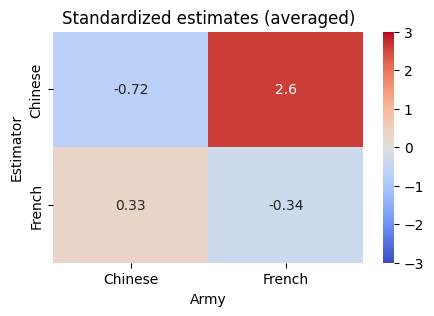

In [6]:
draw_chinese_vs_french_deviations(df)

## Aggregate on swarmplots

### Define input widgets

In [7]:
def focus_to_str(focus):
    return f"{focus['Army']} | {focus['Type']} | {focus['Date']} | {focus['Location']}"



class WidgetMaker:
    def __init__(self, df):
        self.df = df
        self.interactive_widgets = []

    def make_single_focus_filter(self):
        focuses = df["Focus"].drop_duplicates()
        options = focuses[focuses.apply(is_focus_valid, df=df, axis=1)].apply(focus_to_str, axis=1).tolist()
        widget = widgets.Dropdown(
            options=options,
            value=options[0],
            description="Focus",
            layout={"height": "30px", "width": "600px"}
        )
        self.interactive_widgets.append(widget)
        return widget

    def make_focus_filter(self):
        focuses = df["Focus"].drop_duplicates()
        options = focuses[focuses.apply(is_focus_valid, df=df, axis=1)].apply(focus_to_str, axis=1).tolist()
        widget = widgets.SelectMultiple(
            options=options,
            value=options,
            description="Focus",
            layout={"height": "140px", "width": "600px"}
        )
        self.interactive_widgets.append(widget)
        return widget

    def make_army_filter(self):
        options = df[("Focus", "Army")].drop_duplicates().tolist()
        widget = widgets.SelectMultiple(
            options=options,
            value=options,
            description="Army",
            layout={"height": "140px", "width": "180px"}
        )
        self.interactive_widgets.append(widget)
        return widget

    def make_focus_type_filter(self):
        options = df[("Focus", "Type")].drop_duplicates().tolist()
        widget = widgets.SelectMultiple(
            options=options,
            value=options,
            description="Type",
            layout={"height": "140px", "width": "180px"}
        )
        self.interactive_widgets.append(widget)
        return widget

    def make_estimator_filter(self):
        options = df["Estimator"].drop_duplicates().tolist()
        widget = widgets.SelectMultiple(
            options=options,
            value=options,
            description="Estimator",
            layout={"height": "140px", "width": "600px"}
        )
        self.interactive_widgets.append(widget)
        return widget

    def make_nationality_filter(self):
        options = df["Estimator nationality"].drop_duplicates().tolist()
        widget = widgets.SelectMultiple(
            options=options,
            value=options,
            description="Nationality",
            layout={"height": "140px", "width": "180px"}
        )
        self.interactive_widgets.append(widget)
        return widget

    def make_estimator_status_filter(self):
        options = df["Estimator status"].drop_duplicates().tolist()
        widget = widgets.SelectMultiple(
            options=options,
            value=options,
            description="Status",
            layout={"height": "140px", "width": "180px"}
        )
        self.interactive_widgets.append(widget)
        return widget
    
    def make_estimation_date_filter(self):
        options = df["Estimation date < 1940"].drop_duplicates().tolist()
        widget = widgets.SelectMultiple(
            options=options,
            value=[True],
            description="Estimation date < 1940",
            layout={"height": "50px", "width": "300px"}
        )
        self.interactive_widgets.append(widget)
        return widget

    def make_color_pickers(self):
        DEFAULT_NATIONALITY_COLOR_MAP = {
          "FRA": "#274EA8",
          "CHI": "#F7D21B",
          "UK" : "#B22B43",
          "TAI": "#ED587D",
          "JAP": "#DC9FB4",
          "USA": "#7FCEA8",
          "CAN": "#A8E1C5",
          "N/D": "#A598AD"
        }
        widgets_ = [
            widgets.ColorPicker(
                concise=True,
                description=nationality,
                value=DEFAULT_NATIONALITY_COLOR_MAP[nationality],
                layout={"width": "120px"}
            )
            for nationality in DEFAULT_NATIONALITY_COLOR_MAP.keys()
        ]
        self.interactive_widgets += widgets_
        return widgets_

    def make_estimator_to_highlight_dropdown(self):
        options = ["None"] + df["Estimator"].drop_duplicates().tolist()
        widget = widgets.Dropdown(
            options=options,
            value="None",
            description="Estimator"
        )
        self.interactive_widgets.append(widget)
        return widget

    def make_standardization_toggle(self):
        widget = widgets.ToggleButtons(
            options=["Enabled ", "Disabled "],
            tooltips=[
                "Makes comparison possible across different focuses",
                "Prevents comparing events from different distributions"
            ],
            icons=["check", "times"]
        )
        self.interactive_widgets.append(widget)
        return widget

In [8]:
def make_layout():
    filters_grid = widgets.GridspecLayout(3, 3)
    filters_grid[1, 0] = focus_filter_stack
    filters_grid[1, 1] = army_filter
    filters_grid[1, 2] = focus_type_filter
    filters_grid[0, 0] = estimator_filter
    filters_grid[0, 1] = nationality_filter
    filters_grid[0, 2] = estimator_status_filter
    filters_grid[2, 0] = estimation_date_filter

    tabs = widgets.Tab(children=[
        filters_grid,
        widgets.VBox([
            widgets.HTML(value="<h3>Highlight a specific estimator</h3>"),
            widgets.HBox([estimator_to_highlight_dropdown]),
            widgets.HTML(value="<h3>Nationalities</h3>"),
            widgets.HBox(color_pickers)
        ]),
        widgets.HBox([standardization_toggle]),
    ], titles=("Filters", "Colors", "Standardization"))
    # Google Colab doesn't support ipywidgets>=8, and previous versions require this ugly syntax to set tab titles
    tabs.set_title(0, "Filters")
    tabs.set_title(1, "Colors")
    tabs.set_title(2, "Standardization")
    return tabs


class CustomStack(widgets.Box):
    """We can't use `widgets.Stack` because Colab doesn't support ipywidgets>=8, so we implement our own ugly patch"""
    def select_index(self, index):
        for child in self.children:
            child.layout.display = "none"
        self.children[index].layout.display = "flex"

### Define plot

In [9]:
def draw(**kwargs):
    # update standardization mode
    should_standardize = standardization_toggle.value == standardization_toggle.options[0]
    if should_standardize:
        focus_filter_stack.select_index(0)
        army_filter.layout.visibility = "visible"
        focus_type_filter.layout.visibility = "visible"
        title = "Normalized deviation from median"
        y = "Deviation"
        focuses = focus_filter.value
    else:
        focus_filter_stack.select_index(1)
        army_filter.layout.visibility = "hidden"
        focus_type_filter.layout.visibility = "hidden"
        army_filter.value = army_filter.options
        focus_type_filter.value = focus_type_filter.options
        title = "Estimates"
        y = "Estimate"
        focuses = [single_focus_filter.value]

    # filter df
    filtered_df = df[(df["Estimator nationality"].isin(nationality_filter.value)) &
                     (df["Estimator status"].isin(estimator_status_filter.value)) &
                     (df["Estimation date < 1940"].isin(estimation_date_filter.value)) &
                     (df[("Focus", "Army")].isin(army_filter.value)) &
                     (df[("Focus", "Type")].isin(focus_type_filter.value)) &
                     (df["Estimator"].isin(estimator_filter.value)) &
                     (df["Focus"].apply(focus_to_str, axis=1).isin(focuses))]

    # choose colors
    should_highlight_estimator = estimator_to_highlight_dropdown.value != "None"
    if should_highlight_estimator:
        color_map = {estimator: ("red" if estimator == estimator_to_highlight_dropdown.value else "grey") for estimator in df["Estimator"].drop_duplicates()}
        hue = "Estimator"
    else:
        color_map = {color_picker.description: color_picker.value for color_picker in color_pickers}
        hue = "Estimator nationality"
    hue_order = [e for e in color_map.keys() if e in filtered_df[hue].values]
    palette = sns.color_palette([color_map[e] for e in hue_order])
    legend = not should_highlight_estimator

    # plot
    plt.figure(figsize=(12, 7))
    if filtered_df.shape[0] > 0:
        sns.swarmplot(x=None,
                      y=y,
                      data=filtered_df,
                      hue=hue,
                      hue_order=hue_order,
                      palette=palette,
                      legend=legend)
    plt.axhline(y=0, color="black", linestyle="dotted", linewidth=1)
    if should_standardize:
        plt.ylim(-10, 10)
        plt.yticks([-10, -5, 0, 5, 10])
    elif filtered_df.shape[0] > 0:
        plt.ylim(0, int(1 + filtered_df["Estimate"].max() * 1.1))
        plt.yticks([int(e) for e in plt.yticks()[0]])
    plt.xticks([])
    plt.ylabel(None)
    plt.title(title)
    plt.show()

### Display widgets and plot

In [10]:
widget_maker = WidgetMaker(df)
focus_filter = widget_maker.make_focus_filter()
single_focus_filter = widget_maker.make_single_focus_filter()
army_filter = widget_maker.make_army_filter()
focus_type_filter = widget_maker.make_focus_type_filter()
estimator_filter = widget_maker.make_estimator_filter()
nationality_filter = widget_maker.make_nationality_filter()
estimator_status_filter = widget_maker.make_estimator_status_filter()
estimation_date_filter = widget_maker.make_estimation_date_filter()
color_pickers = widget_maker.make_color_pickers()
estimator_to_highlight_dropdown = widget_maker.make_estimator_to_highlight_dropdown()
standardization_toggle = widget_maker.make_standardization_toggle()

focus_filter_stack = CustomStack([focus_filter, single_focus_filter])

out = widgets.interactive_output(draw, {str(i): e for i, e in enumerate(widget_maker.interactive_widgets)})
out.layout.height = "700px"
display(make_layout(), out)

Output(layout=Layout(height='700px'))